In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import tracker
import stats
import visualizer
import utils

from tqdm import trange

import importlib

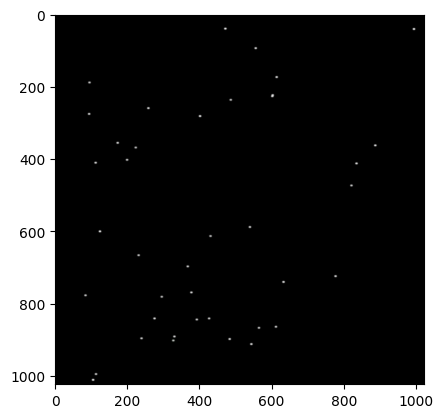

In [2]:
videofile = "ExampleVideos/synthetic40.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

In [3]:
# Load groundtruth dataframe
df = utils.loadDataFrame("ExampleVideos/synthetic40.csv")

def compute_deltas(df_in):

    df = df_in.copy()

    # Compute delta_x and delta_y columns for each sperm id and frame
    for index, row in df.iterrows():
        if row['frame'] > 0:
            prev_row = df[(df['sperm'] == row['sperm']) & (df['frame'] == row['frame'] - 1)]
            if not prev_row.empty:
                df.at[index, 'delta_x'] = row['x'] - prev_row.iloc[0]['x']
                df.at[index, 'delta_y'] = row['y'] - prev_row.iloc[0]['y']
            else:
                df.at[index, 'delta_x'] = 0
                df.at[index, 'delta_y'] = 0
    else:
        df.at[index, 'delta_x'] = 0
        df.at[index, 'delta_y'] = 0

    return df

df = compute_deltas(df)

### Train movement predictor

In [9]:
# Create sliding window forecast dataset

def create_sliding_window_dataset(df, window_size=5, target_size=5):
    X = []
    y = []

    for index, row in df.iterrows():
        if row['frame'] >= window_size:
            features = []
            for w in range(window_size):
                prev_row = df[(df['sperm'] == row['sperm']) & (df['frame'] == row['frame'] - w)]
                if not prev_row.empty:
                    features.extend([prev_row.iloc[0]['delta_x'], prev_row.iloc[0]['delta_y']])
                else:
                    features.extend([0, 0])
            X.append(features)
            outputs = []
            for t in range(target_size):
                out_row = df[(df['sperm'] == row['sperm']) & (df['frame'] == row['frame'] + t)]
                if not out_row.empty:
                    outputs.extend([out_row.iloc[0]['delta_x'], out_row.iloc[0]['delta_y']])
                else:
                    outputs.extend([0, 0])
            y.append(outputs)

    return np.array(X), np.array(y)

X, y = create_sliding_window_dataset(df, window_size=5, target_size=5)

print(X.shape, y.shape) # Currently delta_x and delta_y are in the same dimension 

(10600, 10) (10600, 10)


In [10]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500)
model.fit(X, y)

MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500)

In [11]:
# Test set
test_df = utils.loadDataFrame("ExampleVideos/synthetic10.csv")
test_df = compute_deltas(test_df)
X_test, y_test = create_sliding_window_dataset(test_df, window_size=5, target_size=5)
predictions = model.predict(X_test)

# Evaluate the model
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.1556008804198276


### Visualize Predictor Performance

Sperm 36


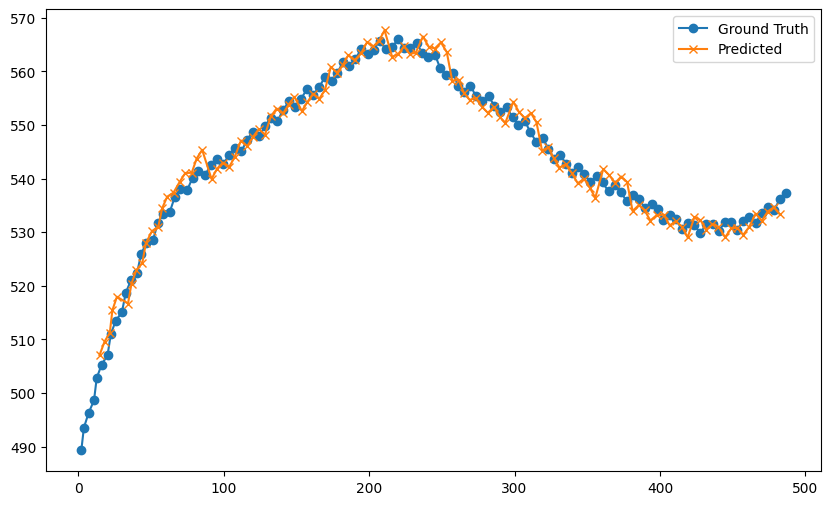

In [12]:
test_df = utils.loadDataFrame("ExampleVideos/synthetic10.csv")
test_df = compute_deltas(test_df)

#sperm_id = np.random.choice(test_df["sperm"].unique(), 1)[0]
sperm_id = 36
sperm = test_df[test_df["sperm"] == sperm_id]
# Get the sperm trajectory
sperm = sperm[["frame", "x", "y","delta_x","delta_y"]].to_numpy()

# Predict the trajectory in target_size chunks
window_size = 5
target_size = 5
predicted_positions = []

for i in range(window_size, len(sperm) - target_size + 1, target_size):
    input_window = []
    for w in range(window_size):
        input_window.extend([sperm[i - w - 1][3], sperm[i - w - 1][4]])  # delta_x, delta_y
    input_window = np.array(input_window).reshape(1, -1)
    
    prediction = model.predict(input_window)[0]
    
    for t in range(target_size):
        if t == 0:
            last_x = sperm[i - 1][1]
            last_y = sperm[i - 1][2]
        pred_dx = prediction[2 * t]
        pred_dy = prediction[2 * t + 1]
        last_x += pred_dx
        last_y += pred_dy
        predicted_positions.append((last_x, last_y))

# Plot actual vs predicted
predicted_positions = np.array(predicted_positions)
print("Sperm", sperm_id)
plt.figure(figsize=(10, 6))
plt.plot(sperm[:, 1], sperm[:, 2], label="Ground Truth", marker='o')
plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label="Predicted", marker='x')
plt.legend()
plt.show()




### Create forecasting based tracker

In [25]:
# Start with perfect detections for now
test_df = utils.loadDataFrame("ExampleVideos/synthetic40.csv")
test_df = test_df.drop(columns=['sperm']) # Remove sperm ids

def forecast_tracker(df, model, window_size=5, target_size=5, dist_cutoff=20, epsilon_cutoff=4):
    
    # Make sperm ids column
    df['sperm'] = -1  # Initialize sperm ids with -1


    ### INITIAL TRACKING PHASE ###

    # Iterate through each frame, try to link from previous frame
    max_frame = df['frame'].max()
    tracked_df = df[df['frame'] == 0].copy() # Start with first frame detections
    tracked_df['sperm'] = range(len(tracked_df)) # Assign initial sperm ids

    # While the window size is not met, match purely on distance
    for frame in range(1, window_size):
        prev_frame_df = tracked_df[tracked_df['frame'] == frame - 1].copy()
        curr_frame_df = df[df['frame'] == frame].copy()

        # Match based on nearest neighbor
        for index, row in curr_frame_df.iterrows():
            distances = np.sqrt((prev_frame_df['x'] - row['x'])**2 + (prev_frame_df['y'] - row['y'])**2)
            if not distances.empty:
                min_index = distances.idxmin()
                curr_frame_df.at[index, 'sperm'] = prev_frame_df.at[min_index, 'sperm']
        
        # Assign new sperm ids to unmatched detections
        unmatched = curr_frame_df[curr_frame_df['sperm'] == -1]
        next_sperm_id = tracked_df['sperm'].max() + 1
        for index, row in unmatched.iterrows():
            curr_frame_df.at[index, 'sperm'] = next_sperm_id
            next_sperm_id += 1
        
        tracked_df = pd.concat([tracked_df, curr_frame_df], ignore_index=True)



    ### MAIN FORECASTING LOOP ###

    # Once the window size is met, use the model to predict next positions
    for frame in range(window_size, max_frame + 1, target_size):
        prev_frame_df = tracked_df[tracked_df['frame'] == frame - 1].copy()
        sperm_preds = {}

        # Create the sliding window for each sperm in previous frames
        for sperm in prev_frame_df['sperm'].unique():
            rows = []
            for w in range(0, window_size):
                cur_row = tracked_df[(tracked_df['sperm'] == sperm) & (tracked_df['frame'] == frame - w)]
                prev_row = tracked_df[(tracked_df['sperm'] == sperm) & (tracked_df['frame'] == frame - w - 1)]
                if not prev_row.empty and not cur_row.empty:
                    delta_x = cur_row.iloc[0]['x'] - prev_row.iloc[0]['x']
                    delta_y = cur_row.iloc[0]['y'] - prev_row.iloc[0]['y']
                    rows.append([delta_x, delta_y])
                else:
                    rows.append([0,0])
            sperm_window = np.array(rows).flatten().reshape(1, -1)
            
            # Predict next t delta_x and delta_y values using the model
            predicted_deltas = model.predict(sperm_window)
            # Update the last known position of the sperm
            last_pos = tracked_df[(tracked_df['sperm'] == sperm) & (tracked_df['frame'] == frame - 1)].iloc[0]
            new_x_vals = last_pos['x'] + np.cumsum(predicted_deltas[0][0:target_size*2:2])
            new_y_vals = last_pos['y'] + np.cumsum(predicted_deltas[0][1:target_size*2:2])

            sperm_preds[sperm] = list(zip(new_x_vals, new_y_vals))


        # Find the nearest detection to the next t frames
        for t in range(target_size):
            if t >= len(new_x_vals):
                break
            curr_frame_df = df[df['frame'] == frame + t]

            for sperm, preds in sperm_preds.items():
                curr_x_val, curr_y_val = preds[t]

                # Find the nearest detection in the current frame to the predicted position
                distances = np.sqrt((curr_frame_df['x'] - curr_x_val)**2 + (curr_frame_df['y'] - curr_y_val)**2)
                if not distances.empty:
                    min_index = distances.idxmin()
                    if distances[min_index] < dist_cutoff:  # Threshold to consider a match
                        if curr_frame_df.at[min_index, 'sperm'] == -1:  # Only assign if not already assigned
                            curr_frame_df.at[min_index, 'sperm'] = sperm
                        else:
                            # Create a new row for with this location copied but new sperm id
                            curr_frame_df = pd.concat([curr_frame_df, pd.DataFrame({
                                'frame': [frame],
                                'x': [curr_frame_df.at[min_index, 'x']],
                                'y': [curr_frame_df.at[min_index, 'y']],
                                'sperm': [sperm]
                            })], ignore_index=True)
            
            tracked_df = pd.concat([tracked_df, curr_frame_df], ignore_index=True)


    ### POST-PROCESSING tracked_df ###

    # Assign new sperm ids to unmatched detections
    unmatched = tracked_df[tracked_df['sperm'] == -1]
    next_sperm_id = tracked_df['sperm'].max() + 1
    remove_indices = []
    for index, row in unmatched.iterrows():
        x = row['x']
        y = row['y']
        frame = row['frame']

        # If the detection is close to a future position on another unmatched detection, link them
        # future_frame_df = tracked_df[tracked_df['frame'] == frame + 1]

        # for sperm in future_frame_df[['sperm']==-1]:
        #         pos = tracked_df[tracked_df['sperm'] == sperm]
        #         dist = np.sqrt((x - pos['x'])**2 + (y - pos['y'])**2).values
        #         distances.append(dist)

        # If the detection is too close to an existing track, remove it
        distances = []
        for sperm in tracked_df[(tracked_df['frame'] == frame)]['sperm'].unique():
            if sperm != -1:
                pos = tracked_df[(tracked_df['sperm'] == sperm) & (tracked_df['frame'] == frame)]
                dist = np.sqrt((x - pos['x'])**2 + (y - pos['y'])**2).values
                if len(dist) > 1:
                    print(sperm, frame, dist)
                    dist = [dist[0]]
                    print(dist)
                distances.append(dist)
        
        # Current ERROR: One sperm id assigned multiple times in the same frame
        distances = np.array(distances)
        if distances.size > 0 and distances.min() < epsilon_cutoff:
            remove_indices.append(index)

        # Otherwise, just assign a new sperm id
        else:
            tracked_df.at[index, 'sperm'] = next_sperm_id
            next_sperm_id += 1
            

    tracked_df = tracked_df.drop(remove_indices)

    return tracked_df

tracked_df = forecast_tracker(test_df, model, window_size=5)
print(tracked_df)

21 15.0 [419.9702449  422.4871687  423.68918249 422.99479779]
[419.97024490185316]
21 15.0 [260.3025401  271.27262925 266.69694156 262.63856387]
[260.30254009778065]
21 15.0 [874.88043309 877.92244074 878.94182435 878.05199211]
[874.8804330905441]
15 20.0 [429.30984057 423.62241422 426.82910628]
[429.30984057194195]
16 20.0 [265.91050511 262.92728842 261.92829195]
[265.9105051072745]
15 20.0 [60.79138892 54.40469974 52.29198988]
[60.79138891529]
16 20.0 [633.59254997 627.75372777 625.76849984]
[633.5925499714328]
15 20.0 [216.65839925 221.78849488 226.0403264 ]
[216.658399254221]
16 20.0 [694.14772539 685.95986735 683.20172188]
[694.1477253896837]
15 20.0 [875.6790891  870.77205367 874.88593451]
[875.6790891008102]
16 20.0 [227.06119263 235.19907497 237.96332745]
[227.0611926277148]
13 25.0 [647.32630851 646.73595725 645.05919106]
[647.3263085072065]
13 25.0 [40.54681217 27.99972174 23.45119085]
[40.54681216912212]
13 25.0 [417.55434705 421.35322842 421.25828318]
[417.55434705164913]
1

In [28]:
# Plot tracks
videofile = "ExampleVideos/synthetic40.mp4"
visualizer.runVisualization(videofile, tracked_df)

(5769, 3)
Video Finished.
